## Preperation

In [109]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import  pyplot as plt

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split

# PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

from torchviz import make_dot, make_dot_from_trace
from tqdm.notebook import tqdm

In [110]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

TARGET='Exited'
RANDOM_STATE=42

In [111]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [112]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [113]:
train.drop(columns=['id','Surname','CustomerId'],inplace=True)
test.drop(columns=['id','Surname','CustomerId'],inplace=True)

In [114]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 13.9+ MB


In [115]:
cat_cols=[col for col in train.columns if train[col].dtype=='O']
cat_cols

['Geography', 'Gender']

In [116]:
LE=LabelEncoder()
for col in cat_cols:
    train[col]=LE.fit_transform(train[col])
    test[col]=LE.transform(test[col])

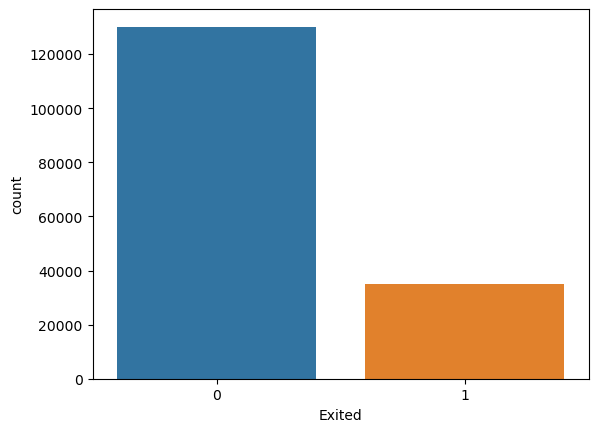

In [117]:
X=train.drop(columns=TARGET,axis=1)
y=train[TARGET]

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,
                                             stratify=y,
                                             random_state=RANDOM_STATE) # straify to maintain the ratio of classes in train and val set
sns.countplot(data=train,x=TARGET);

In [118]:
MMScaler=MinMaxScaler()
X_train=MMScaler.fit_transform(X_train)
X_val=MMScaler.transform(X_val)

In [119]:
# Dataset --> Numpy arrays
X_train,y_train=np.array(X_train,dtype=np.float32),np.array(y_train,dtype=np.float32)
X_val,y_val=np.array(X_val,dtype=np.float32),np.array(y_val,dtype=np.float32)

In [120]:
BATCH_SIZE=64
NUM_FEATURES=X_train.shape[1]
NUM_CLASSES=train[TARGET].nunique()
NUM_EPOCHS=100

In [121]:
device=torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")
print(device)

cpu


## Dataset Classes

In [122]:
class ChurnDataset(Dataset):

    def __init__(self,X_data,y_data):
        self.X_data=X_data
        self.y_data=y_data

    def __getitem__(self,index):
        return self.X_data[index],self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)


In [123]:
# torch arrays
train_dataset=ChurnDataset(torch.from_numpy(X_train).float(),
                           torch.from_numpy(y_train).long())
val_dataset=ChurnDataset(torch.from_numpy(X_val).float(),
                           torch.from_numpy(y_val).long())

**Dataloaders** in PyTorch are a utility that `helps in loading and preprocessing data` for training or inference. 
They provide an efficient way to iterate over a dataset, handle batching, shuffling, and parallel data loading. 
Dataloaders are commonly used in deep learning tasks, where large datasets need to be processed in mini-batches. 
PyTorch's Dataloader class provides various options to customize the data loading process, such as setting the batch size, enabling shuffling, specifying the number of workers for parallel loading, and more. 
By using Dataloaders, developers can easily manage and feed data to their models during the training or evaluation phase.

```py
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
```


In [124]:
# Dataloaders
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
val_loader=DataLoader(dataset=val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=True)

In [125]:
dataiter=iter(train_loader) # iterator--> return one element at a time
train_features,train_labels=dataiter._next_data() # get next batch of data

# Get first batch
print("Batch #1")
print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")
print(f"First row of batch 1:\n {train_features[1]}")

# batch 2
train_features, train_labels=dataiter._next_data()
print("\nBatch #2")
print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")
print(f"First row of batch 2:\n {train_features[2]}")


Batch #1
Feature batch shape: torch.Size([64, 10])
Label batch shape: torch.Size([64])
First row of batch 1:
 tensor([0.5740, 0.0000, 0.0000, 0.1486, 0.0000, 0.0000, 0.3333, 1.0000, 0.0000,
        0.8007])

Batch #2
Feature batch shape: torch.Size([64, 10])
Label batch shape: torch.Size([64])
First row of batch 2:
 tensor([0.7980, 0.0000, 1.0000, 0.2838, 0.4000, 0.0000, 0.3333, 1.0000, 1.0000,
        0.1813])


In [126]:
class ChurnNetModule(nn.Module):
    def __init__(self,num_features,num_classes):
        super(ChurnNetModule,self).__init__()

        self.layer_1=nn.Linear(num_features,512)
        self.layer_2=nn.Linear(512,256)
        self.layer_3=nn.Linear(256,128)
        self.layer_out=nn.Linear(128,1)

        torch.nn.init.xavier_normal_(self.layer_1.weight) # initialize weights
        torch.nn.init.xavier_normal_(self.layer_2.weight)
        torch.nn.init.xavier_normal_(self.layer_3.weight)
        torch.nn.init.xavier_normal_(self.layer_out.weight)

        self.dropout_1=nn.Dropout(p=0.3)
        self.dropout_2=nn.Dropout(p=0.2)

        self.batchnorm1=nn.BatchNorm1d(512)
        self.batchnorm2=nn.BatchNorm1d(256)
        self.batchnorm3=nn.BatchNorm1d(128)

        self.relu=nn.ReLU()
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(dim=1)
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):

        x=self.layer_1(x)
        x=self.relu(x)
        x=self.batchnorm1(x)
        x=self.dropout_1(x)

        x=self.layer_2(x)
        x=self.tanh(x)
        x=self.batchnorm2(x)
        x=self.dropout_2(x)

        x=self.layer_3(x)
        x=self.relu(x)
        x=self.batchnorm3(x)
        x=self.dropout_2(x)

        x=self.layer_out(x)
        x=self.sigmoid(x)
        return x


        
        

In [127]:
# create a model using Module
modelModule=ChurnNetModule(num_features=NUM_FEATURES,num_classes=NUM_CLASSES)
modelModule.to(device)
modelModule.eval()

ChurnNetModule(
  (layer_1): Linear(in_features=10, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)

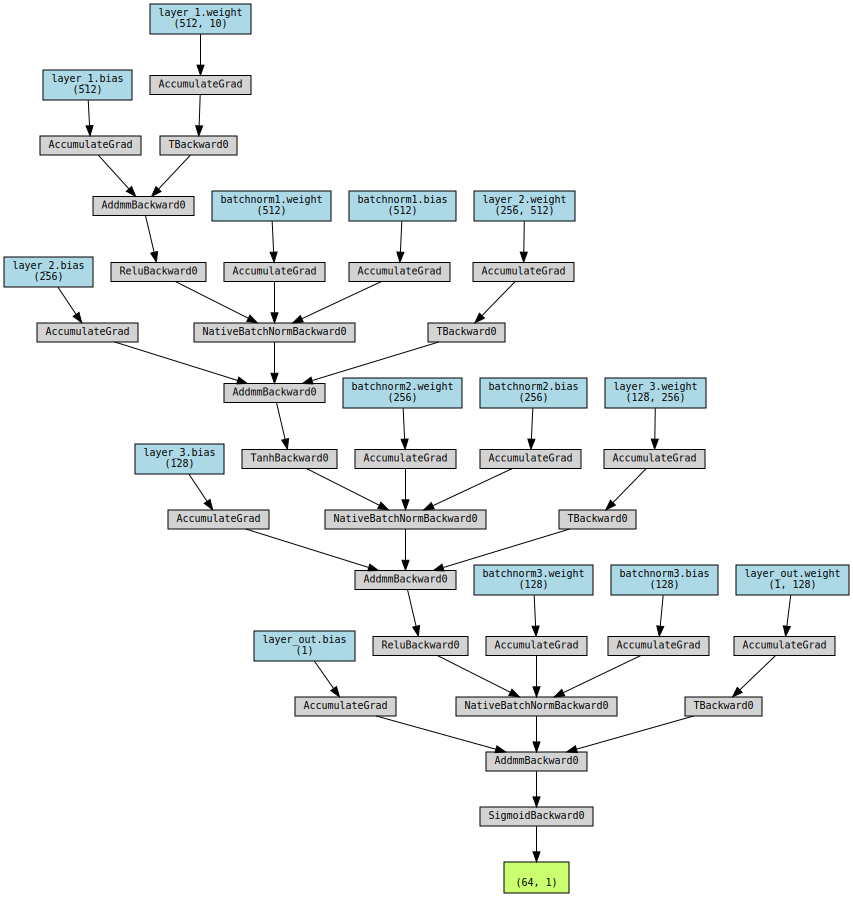

In [128]:
# visualize the model

make_dot(modelModule(train_features),params=dict(modelModule.named_parameters())) 

In [131]:
model=modelModule
LEARNING_RATE=0.002
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE)

from torch.optim.lr_scheduler import ReduceLROnPlateau
sheduler=ReduceLROnPlateau(optimizer=optimizer,
                           mode='min',
                           patience=5)



## Train and Validation loop

In [161]:
accuracy_stat={'train':[],'validation':[]}
loss_stat={'train':[],'validation':[]}

def acc_clac(y_pred,y_test):
    y_pred_tag=torch.round(y_pred)
    correct_results=(y_pred_tag==y_test).sum().float()
    accuracy=correct_results/y_test.shape[0]
    accuracy=torch.round(accuracy*100)
    return accuracy



## Callback

In [162]:
class EarlyStoppingCallback:
    def __init__(self,min_delta=0.1,patience=5):
        self.min_delta=min_delta
        self.patience=patience
        self.best_epoch_score=0

        self.attempt=0
        self.best_score=None
        self.stop_training=False

    def __call__(self,validation_loss):
        self.epoch_score=validation_loss

        if self.best_epoch_score==0:
            self.best_epoch_score=self.epoch_score

        elif self.epoch_score>self.best_epoch_score-self.min_delta:
            self.attempt+=1
            print(f"Message from Callback (Earlystopping) counter: {self.attempt}")
            if self.attempt>=self.patience:
                self.stop_training=True
        else:
            self.best_epoch_score=self.epoch_score
            self.attempt=0
            

In [152]:
def train_nn():
    for epoch in tqdm(range(1,NUM_EPOCHS+1)):
        train_epoch_loss=0
        train_epoch_acc=0

        model.train()

        for X_train_batch,y_train_batch

[0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]